<a href="https://colab.research.google.com/github/DvirHayat/BAYU-Net/blob/main/BayuNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Install required libraries

In [ ]:
# Install the ultralytics package
!pip install ultralytics

!pip install -q segmentation-models-pytorch --no-deps
!pip install -U torchmetrics
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
# --- Core Python ---
import io
import os
import random
from datetime import datetime

# --- Data Science / Display ---
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display

# --- Colab-Specific ---
from google.colab.patches import cv2_imshow

# --- Torch / Deep Learning ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# --- Segmentation Models ---
import segmentation_models_pytorch as smp

# --- Torchmetrics (for IoU/Jaccard) ---
from torchmetrics.classification import BinaryJaccardIndex

# --- OpenCV ---
import cv2

# --- Ultralytics YOLO ---
from ultralytics import YOLO

# --- Widgets ---
import ipywidgets as widgets


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
yolo_model_path = "/content/drive/MyDrive/yolo_model.pt"
unet_model_path = "/content/drive/MyDrive/Unet/unet_model_weights_ep_100_bs_4.pth"

In [ ]:
# Load the model
yolo_model = YOLO(yolo_model_path)

# Summary
print("✅ YOLO model loaded successfully")
print(f"  - Model type: {type(yolo_model.model).__name__}")
print(f"  - Input size: {yolo_model.model.yaml.get('imgsz', 'Unknown')}")
print(f"  - Number of classes: {yolo_model.model.nc}")
print(f"  - Class names: {yolo_model.model.names}")

✅ YOLO model loaded successfully
  - Model type: DetectionModel
  - Input size: Unknown
  - Number of classes: 1
  - Class names: {0: 'vertebrea'}


In [ ]:
unet_model = smp.Unet(
    encoder_name="resnext50_32x4d",
    encoder_weights=None,
    in_channels=3,
    classes=1
)

# Load weights
unet_model.load_state_dict(torch.load(unet_model_path))
unet_model.eval()

# Get output channels from last Conv2d layer
out_channels = unet_model.segmentation_head[0].out_channels if isinstance(unet_model.segmentation_head, torch.nn.Sequential) \
    else unet_model.segmentation_head.out_channels if hasattr(unet_model.segmentation_head, "out_channels") \
    else unet_model.segmentation_head.__dict__.get("out_channels", "Unknown")

# Summary
print("✅ U-Net model loaded successfully")
print(f"  - Encoder: {unet_model.encoder.__class__.__name__}")
print(f"  - Decoder blocks: {len(unet_model.decoder.blocks)}")
print(f"  - Input channels: {unet_model.encoder.conv1.in_channels}")
print(f"  - Output channels (classes): {out_channels}")
print(f"  - Attention type: {unet_model.decoder.blocks[0].attention1.__class__.__name__}")


✅ U-Net model loaded successfully
  - Encoder: ResNetEncoder
  - Decoder blocks: 5
  - Input channels: 3
  - Output channels (classes): 1
  - Attention type: Attention


#### Image process function

In [ ]:
import cv2
import numpy as np

class ImageUtils:

    @staticmethod
    def crop_image(orig_img, x1, y1, x2, y2):
        try:
            if orig_img is None:
                raise ValueError("Input image is None")

            height, width = orig_img.shape[:2]
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            if x1 < 0 or y1 < 0 or x2 > width or y2 > height:
                raise ValueError("Crop coordinates out of bounds")
            if x2 <= x1 or y2 <= y1:
                raise ValueError("Invalid crop box")

            return orig_img[y1:y2, x1:x2]

        except Exception as e:
            print(f"[ERROR] crop_image failed: {e}")
            return None

    @staticmethod
    def center_and_padd_image(image, target_width, target_height):
        try:
            if image is None or not isinstance(image, np.ndarray):
                raise ValueError("Invalid input image")

            img_height, img_width = image.shape[:2]
            if target_width < img_width or target_height < img_height:
                raise ValueError("Target size must be larger than input")

            x_pad = target_width - img_width
            y_pad = target_height - img_height

            left = x_pad // 2
            right = x_pad - left
            top = y_pad // 2
            bottom = y_pad - top

            return cv2.copyMakeBorder(
                image, top, bottom, left, right,
                borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0]
            )

        except Exception as e:
            print(f"[ERROR] center_and_padd_image failed: {e}")
            return None

    @staticmethod
    def remove_padding(padded_image, original_width, original_height):
        # Remove padding and restore original cropped size from the padded image
        padded_height, padded_width = padded_image.shape[:2]
        x_pad = padded_width - original_width
        y_pad = padded_height - original_height
        left = x_pad // 2
        top = y_pad // 2
        right = left + original_width
        bottom = top + original_height
        return padded_image[top:bottom, left:right]


    @staticmethod
    def keep_largest_object(mask):
        mask = mask.astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        if num_labels <= 1:
            return mask

        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        largest_mask = (labels == largest_label).astype(np.uint8)

        h, w = largest_mask.shape
        flood = largest_mask.copy()
        floodfill_mask = np.zeros((h + 2, w + 2), np.uint8)
        cv2.floodFill(flood, floodfill_mask, (0, 0), 255)
        holes = cv2.bitwise_not(flood)
        filled = cv2.bitwise_or(largest_mask * 255, holes)

        return (filled > 0).astype(np.uint8)


    @staticmethod
    def get_mask_center(mask, box):
        """
        Compute the (x, y) center of a binary mask relative to the full image.

        Parameters:
        - mask: 2D binary NumPy array (mask cropped to the bounding box)
        - box: [x1, y1, x2, y2] bounding box used to crop the mask

        Returns:
        - (x, y) tuple in full image coordinates or None if mask is empty
        """
        if mask is None or np.count_nonzero(mask) == 0:
            return None

        coords = np.argwhere(mask == 1)
        center_yx = coords.mean(axis=0)
        center_xy = center_yx[::-1]  # (x, y)

        x1, y1 = map(int, box[:2])
        center_full_xy = (int(center_xy[0] + x1), int(center_xy[1] + y1))
        return center_full_xy


#### Class Definitions

In [ ]:
class PredictionResult:

    def __init__(self, original, yolo_result):
        self.original = original
        self.yolo_result = yolo_result
        self.boxes = yolo_result.boxes.xyxy.cpu().numpy()

        self.box = []
        self.cropped = []
        self.padded = []
        self.mask_cropped = []
        self.overlay = []
        self.centers = []


    def __getitem__(self, idx):
        """Return tuple of all values at given index, including center."""
        return (
            self.box[idx],
            self.cropped[idx],
            self.padded[idx],
            self.mask_cropped[idx],
            self.overlay[idx],
            self.centers[idx]
        )



    def add_unet_result(self, box, cropped, padded, mask_cropped, overlays):
        self.box.append(box)
        self.cropped.append(cropped)
        self.padded.append(padded)
        self.mask_cropped.append(mask_cropped)
        self.overlay.append(overlays)
        self.centers.append(ImageUtils.get_mask_center(mask_cropped, box))


    def plot_centers_on_overlay(self, idx=-1, color=(255, 0, 0), radius=5):
        """
        Plot the center of the mask (adjusted to full image) on the overlay.
        """
        if idx >= len(self.box) or idx < -len(self.box):
            print("Invalid index.")
            return

        box = self.box[idx]
        mask = self.mask_cropped[idx]
        overlay = self.overlay[idx]

        center_full_xy = ImageUtils.get_mask_center(mask, box)
        if center_full_xy is None:
            print(f"No valid center found for index {idx}.")
            return

        overlay_with_center = overlay.copy()
        cv2.circle(overlay_with_center, center_full_xy, radius, color, -1)

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(overlay_with_center, cv2.COLOR_BGR2RGB))
        plt.title(f"Overlay with Center (idx={idx}) at {center_full_xy}")
        plt.axis("off")
        plt.show()


    def plot_original_image(self):
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image | shape: {self.original.shape}")
        plt.axis("off")
        plt.show()




    def plot_center_lines_graph(
        self,
        by='y',
        color='g',
        linewidth=2,
        show_points=False,
        point_color='r',
        save_path=None,
        show=True
    ):
        """
        Plot lines connecting sorted centers using matplotlib.
        Optionally saves the plot as an image (PNG).
        """

        centers = self.get_sorted_centers(by=by)
        if len(centers) < 2:
            print("Not enough centers to plot lines.")
            return

        xs, ys = zip(*centers)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.plot(xs, ys, color=color, linewidth=linewidth)
        if show_points:
            ax.scatter(xs, ys, color=point_color, zorder=3)

        ax.set_title("Center Connection Lines" + (" (with points)" if show_points else ""))
        ax.invert_yaxis()  # Match image coordinates
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid(True)

        if save_path:
            fig.savefig(save_path, bbox_inches='tight')

        if show:
            plt.show()
        else:
            plt.close(fig)

        return fig  # Optional: useful for inline display in notebooks or exporting




    def plot_lines_on_overlay(
        self,
        color=(0, 255, 0),
        thickness=3,
        show=False,
        save_path=None
    ):
        """
        Plot only the lines connecting centers on the image overlay (no circles).
        Optionally display or save the image.
        """
        if not self.overlay:
            print("No overlay to display.")
            return

        overlay_img = self.overlay[-1].copy()
        centers = self.get_sorted_centers(by='y')
        for i in range(len(centers) - 1):
            pt1 = centers[i]
            pt2 = centers[i + 1]
            cv2.line(overlay_img, pt1, pt2, color, thickness)

        if show:
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
            plt.title("Overlay with Center Lines")
            plt.axis("off")
            plt.show()
        if save_path:
            cv2.imwrite(save_path, overlay_img)
        return overlay_img


    def get_sorted_centers(self, by='y'):
        """
        Return list of non-None centers sorted by y (default) or x.
        """
        centers = [c for c in self.centers if c is not None]
        if by == 'y':
            return sorted(centers, key=lambda c: c[1])
        elif by == 'x':
            return sorted(centers, key=lambda c: c[0])
        else:
            raise ValueError("by should be 'x' or 'y'")



    def plot_final_overlay(
        self,
        show_centers=False,
        show_lines=False,
        color=(255, 0, 0),
        radius=5,
        line_color=(0, 255, 0),
        line_thickness=3
    ):
        if not self.overlay:
            print("No overlay to display.")
            return

        final_overlay = self.overlay[-1].copy()
        centers_to_draw = self.get_sorted_centers(by='y')

        # Draw circles
        if show_centers:
            for center in centers_to_draw:
                cv2.circle(final_overlay, center, radius, color, -1)

        # Draw lines
        if show_lines and len(centers_to_draw) > 1:
            for i in range(len(centers_to_draw) - 1):
                pt1 = centers_to_draw[i]
                pt2 = centers_to_draw[i + 1]
                cv2.line(final_overlay, pt1, pt2, line_color, line_thickness)

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(final_overlay, cv2.COLOR_BGR2RGB))
        title = "Final Overlay: YOLO + U-Net Mask"
        if show_centers:
            title += " + Centers"
        if show_lines:
            title += " + Lines"
        plt.title(title)
        plt.axis("off")
        plt.show()


    def plot_lifecycle(
        self,
        idx=-1,
        show_center=True,
        show_original=True,
        show_crop=True,
        show_padded=True,
        show_mask=True,
        show_overlay=True,
        color=(255, 0, 0),
        radius=5
    ):
        """
        Plot selected lifecycle stages of the prediction result at given index.

        Parameters:
        - show_center: whether to draw the center on the overlay
        - show_*: flags to toggle original, crop, padded, mask, overlay views
        """
        box, cropped, padded, mask_cropped, overlay, center = self[idx]

        images = []
        titles = []

        if show_original:
            images.append(cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB))
            titles.append(f"Original | shape: {self.original.shape}")

        if show_crop:
            images.append(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
            titles.append(f"Cropped | shape: {cropped.shape}")

        if show_padded:
            images.append(cv2.cvtColor(padded, cv2.COLOR_BGR2RGB))
            titles.append(f"Padded | shape: {padded.shape}")

        if show_mask:
            mask_rgb = np.stack([mask_cropped * 255]*3, axis=-1).astype(np.uint8)
            images.append(mask_rgb)
            titles.append(f"Mask | shape: {mask_cropped.shape}")

        if show_overlay:
            overlay_display = overlay.copy()
            if show_center and center is not None:
                cv2.circle(overlay_display, center, radius, color, -1)
            images.append(cv2.cvtColor(overlay_display, cv2.COLOR_BGR2RGB))
            titles.append(f"Overlay | shape: {overlay.shape}")

        if not images:
            print("Nothing to plot. All flags are disabled.")
            return

        fig, axes = plt.subplots(1, len(images), figsize=(5 * len(images), 5))
        if len(images) == 1:
            axes = [axes]  # make iterable

        for img, ax, title in zip(images, axes, titles):
            ax.imshow(img)
            ax.set_title(title)
            ax.axis("off")

        plt.tight_layout()
        plt.show()


    def __str__(self):
        header = (
            f"{'Idx':<5} {'Box':<25} {'Cropped':<15} {'Padded':<15} "
            f"{'Mask':<15} {'Overlay':<15}"
        )
        lines = [f"PredictionResult:\n  Original image shape: {self.original.shape}", header]
        lines.append("-" * len(header))

        for idx in range(len(self.box)):
            box_str = f"[{int(self.box[idx][0])},{int(self.box[idx][1])},{int(self.box[idx][2])},{int(self.box[idx][3])}]"
            cropped_shape = str(self.cropped[idx].shape)
            padded_shape = str(self.padded[idx].shape)
            mask_shape = str(self.mask_cropped[idx].shape)
            overlay_shape = str(self.overlay[idx].shape)

            lines.append(
                f"{idx:<5} {box_str:<25} {cropped_shape:<15} {padded_shape:<15} "
                f"{mask_shape:<15} {overlay_shape:<15}"
            )

        return "\n".join(lines)


In [ ]:
class BayuNet:

  def __init__(self, yolo_model, unet_model, fixed_size=(256, 256)):
    self.yolo_model = yolo_model
    self.unet_model = unet_model
    self.fixed_size = fixed_size
    self.results = []  # Stores PredictionResult objects


  def preprocess_unet_patch(self, original, box):
      x1, y1, x2, y2 = map(int, box)
      cropped = ImageUtils.crop_image(original, x1, y1, x2, y2)
      if cropped is None:
          return None, None, None

      padded = ImageUtils.center_and_padd_image(cropped, *self.fixed_size)
      if padded is None:
          return None, None, None

      input_tensor = torch.tensor(padded / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
      return cropped, padded, input_tensor


  def afterprocess_unet_patch(self, pred):
      # Apply sigmoid, binarize, and filter the U-Net prediction
      pred_mask = torch.sigmoid(pred).cpu().numpy()
      binary_mask = (pred_mask > 0.5).astype(np.uint8)
      return ImageUtils.keep_largest_object(binary_mask)

  def predict(self, image_input, visualize=True):
      """
      Accepts either a file path (str) or an image array (numpy.ndarray).
      If given a file path, loads the image.
      If given a NumPy image, saves it temporarily and processes it.
      """

      if isinstance(image_input, str):
          # Load from path
          original = cv2.imread(image_input)
          if original is None:
              raise ValueError(f"Could not load image from path: {image_input}")

      elif isinstance(image_input, np.ndarray):
          # Already an image, use it directly
          original = image_input
      else:
          raise TypeError("Input must be a file path (str) or an image (numpy.ndarray)")

      print(f"img shape is: {original.shape}")

      # Run YOLO model on the original image to detect objects
      yolo_results = self.yolo_model(original)[0]

      result = PredictionResult(original, yolo_results)

      # Extract bounding box coordinates from YOLO results
      boxes = yolo_results.boxes.xyxy.cpu().numpy()

      # Create a copy of the image to draw overlays on
      overlay = original.copy()

      for i, box in enumerate(boxes):
          cropped, padded, input_tensor = self.preprocess_unet_patch(original, box)
          if input_tensor is None:
              continue

          with torch.no_grad():
              self.unet_model.eval()
              pred = self.unet_model(input_tensor)[0][0]
              processed_mask = self.afterprocess_unet_patch(pred)

          x1, y1, x2, y2 = map(int, box)
          h, w = y2 - y1, x2 - x1
          mask_cropped = ImageUtils.remove_padding(processed_mask, w, h)
          if mask_cropped is None:
              continue

          mask_color = np.zeros_like(overlay[y1:y2, x1:x2])
          mask_color[mask_cropped == 1] = [0, 255, 0]
          overlay[y1:y2, x1:x2] = cv2.addWeighted(overlay[y1:y2, x1:x2], 0.6, mask_color, 0.4, 0)

          result.add_unet_result(box, cropped, padded, mask_cropped, overlay.copy())

      self.results.append(result)

      if visualize and self.results:
          self.results[-1].plot_final_overlay()

      return overlay



#### Model initilzation and preformace

img shape is: (512, 512, 3)

0: 640x640 8 vertebreas, 11.4ms
Speed: 3.7ms preprocess, 11.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


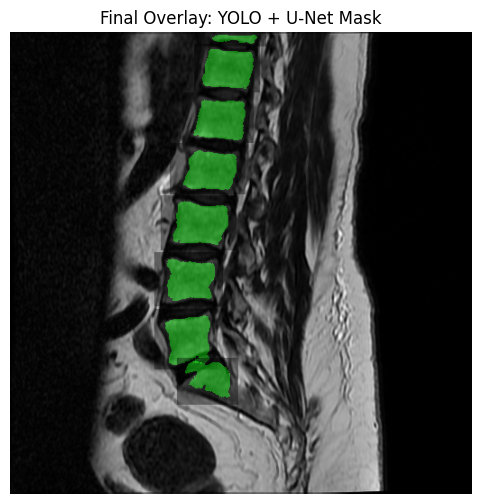

In [ ]:
image_path = "/content/drive/MyDrive/Images/5.png"


model = BayuNet(yolo_model, unet_model)
output_image = model.predict(image_path)


In [ ]:
print(model.results[0])

PredictionResult:
  Original image shape: (512, 512, 3)
Idx   Box                       Cropped         Padded          Mask            Overlay        
-----------------------------------------------------------------------------------------------
0     [167,181,251,242]         (61, 84, 3)     (256, 256, 3)   (61, 84)        (512, 512, 3)  
1     [160,244,236,304]         (60, 76, 3)     (256, 256, 3)   (60, 76)        (512, 512, 3)  
2     [160,307,230,374]         (67, 70, 3)     (256, 256, 3)   (67, 70)        (512, 512, 3)  
3     [204,13,277,67]           (54, 73, 3)     (256, 256, 3)   (54, 73)        (512, 512, 3)  
4     [191,67,270,123]          (56, 79, 3)     (256, 256, 3)   (56, 79)        (512, 512, 3)  
5     [177,123,261,180]         (57, 84, 3)     (256, 256, 3)   (57, 84)        (512, 512, 3)  
6     [185,361,253,413]         (52, 68, 3)     (256, 256, 3)   (52, 68)        (512, 512, 3)  
7     [214,0,284,16]            (16, 70, 3)     (256, 256, 3)   (16, 70)        

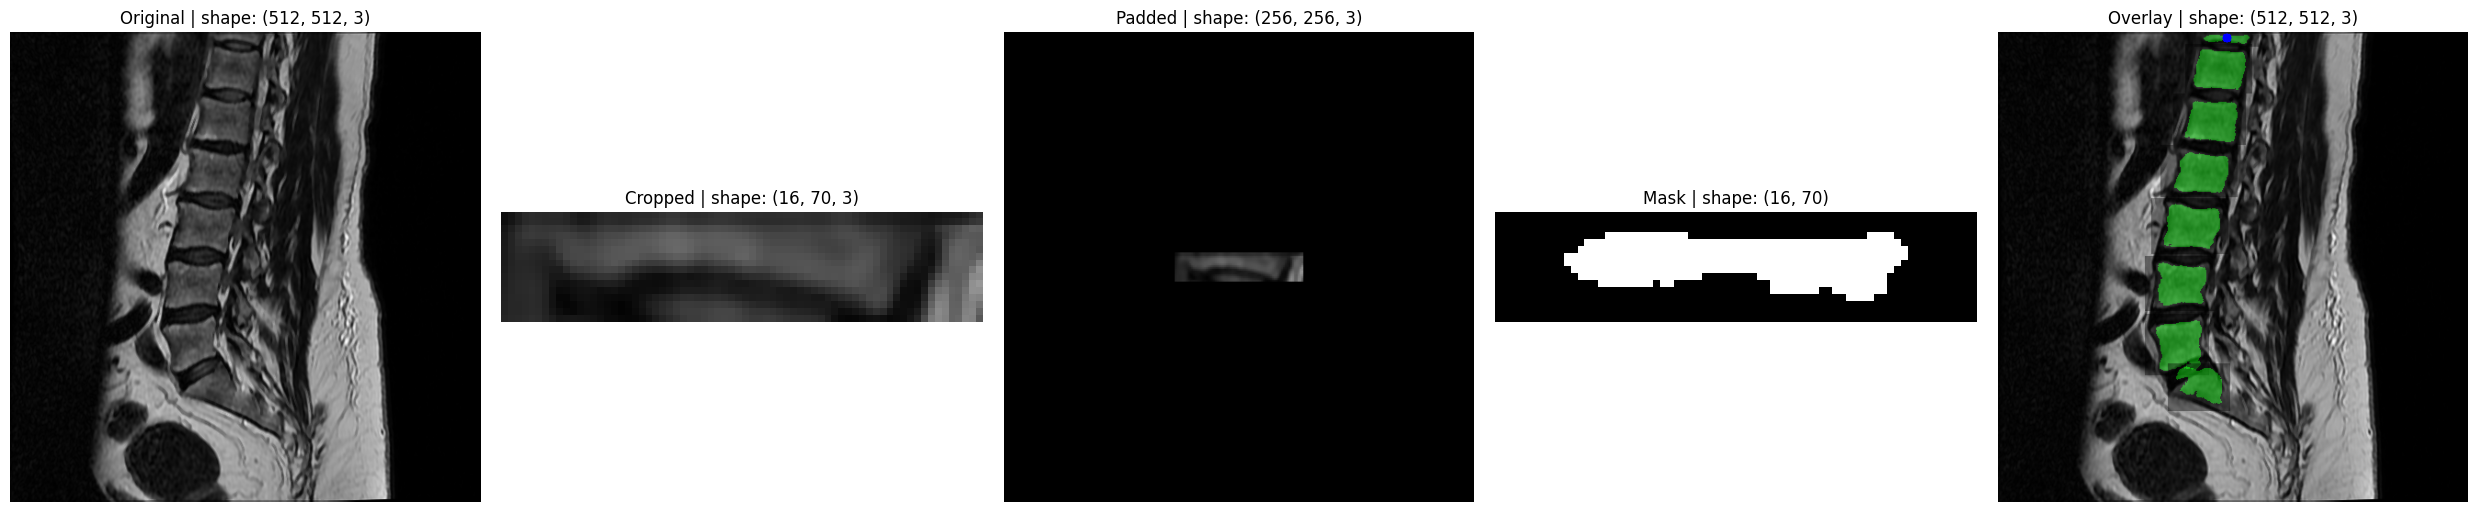

In [ ]:
isx = 0
model.results[isx].plot_lifecycle()

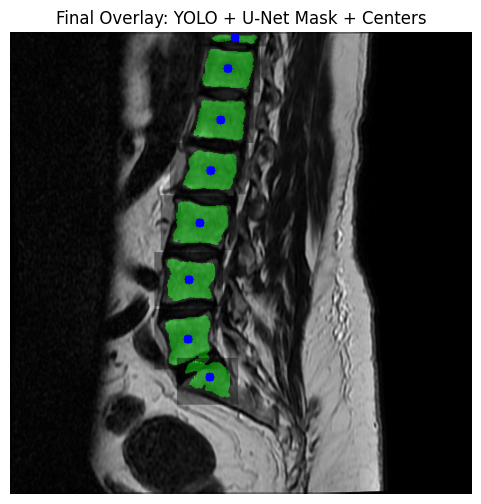

In [ ]:
model.results[isx].plot_final_overlay(True)

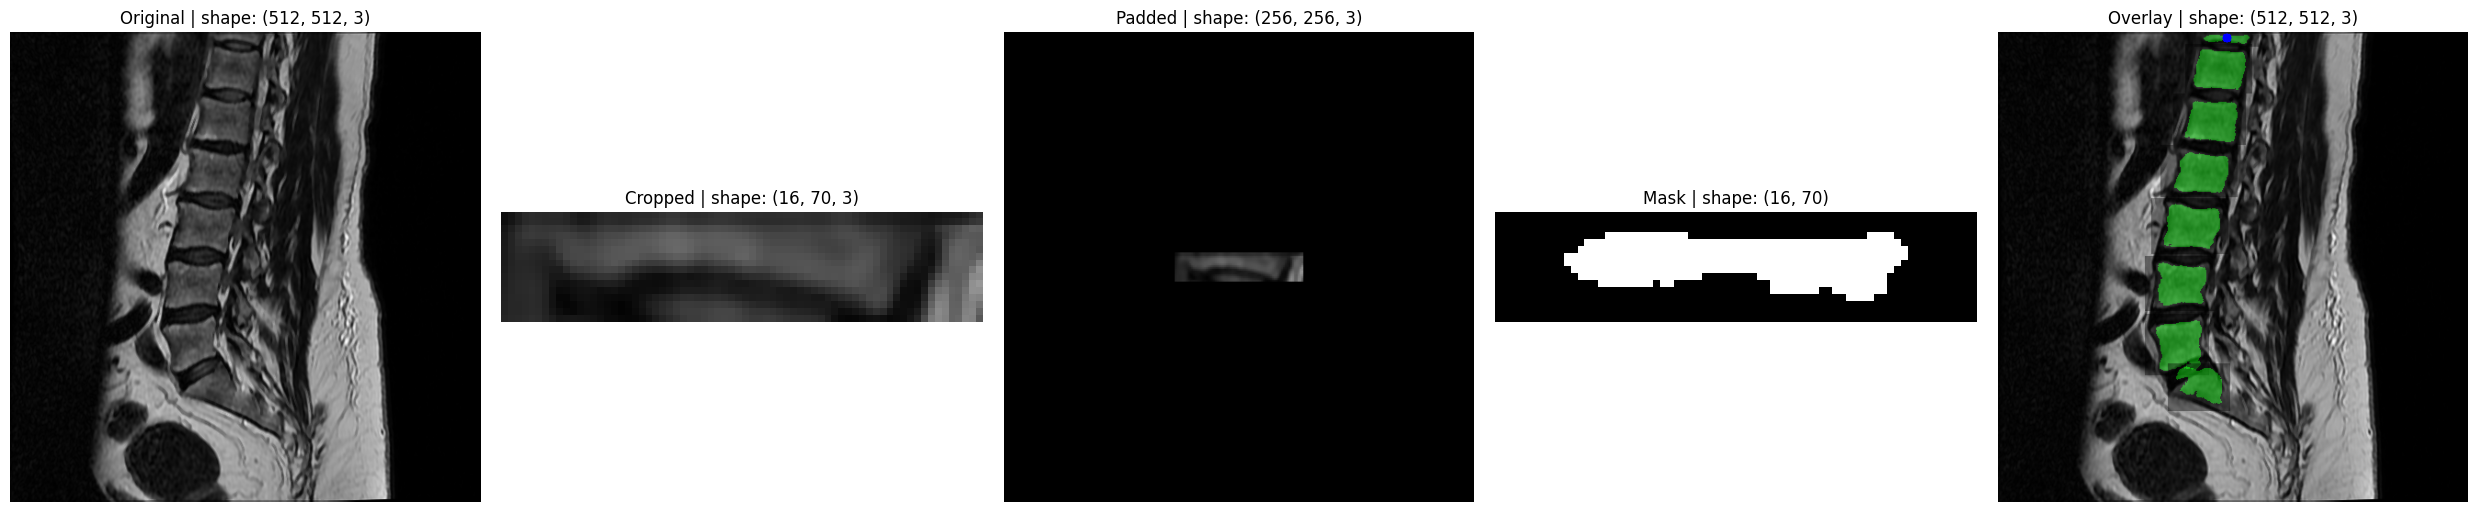

In [ ]:
centers = model.results[isx].plot_lifecycle(idx=-1, show_center=True)

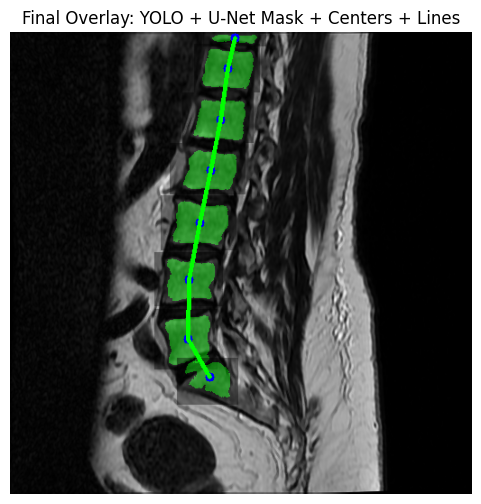

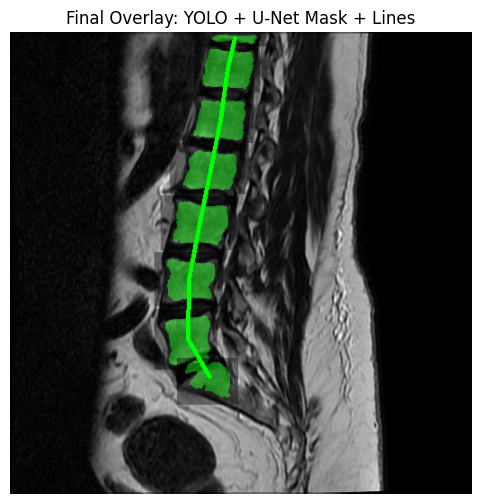

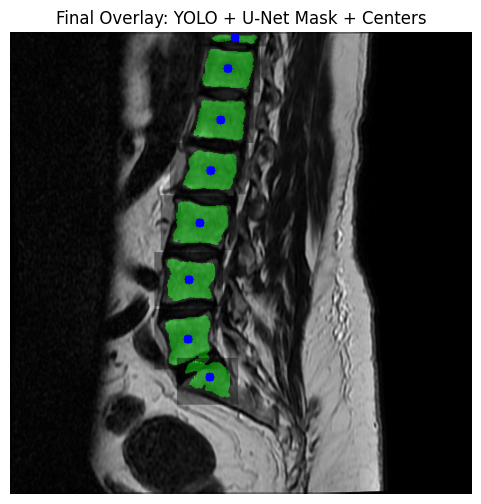

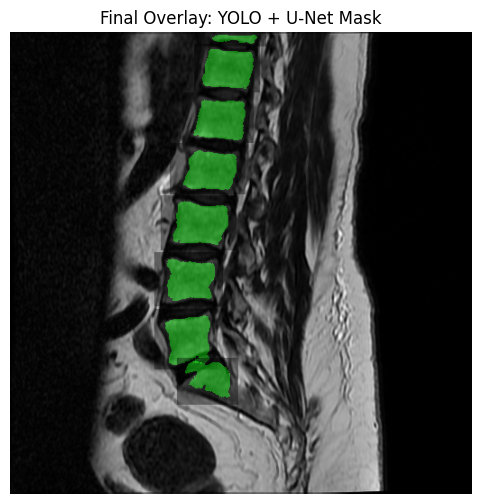

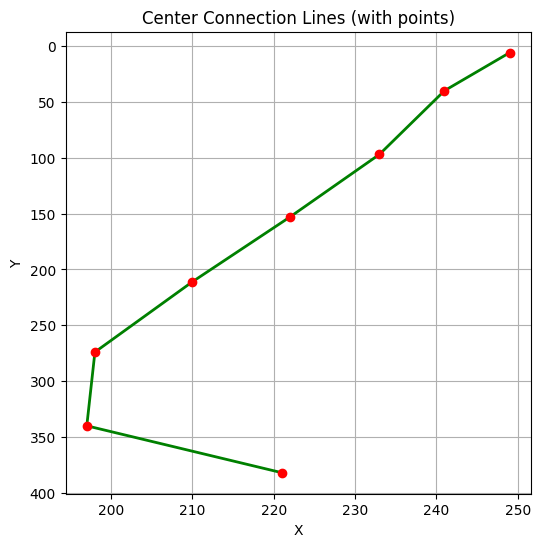

[(249, 6), (241, 40), (233, 97), (222, 153), (210, 211), (198, 274), (197, 340), (221, 382)]


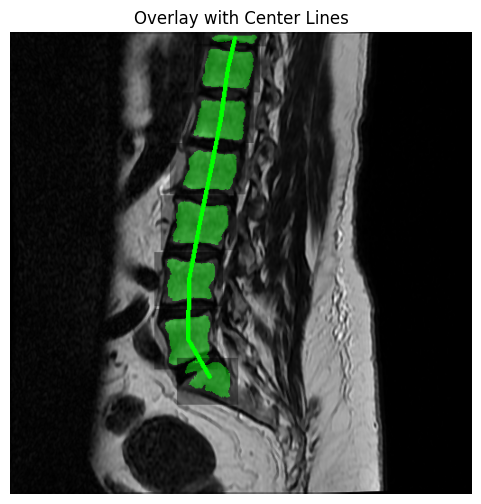

array([[[1, 1, 1],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [6, 6, 6],
        [4, 4, 4],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[5, 5, 5],
        [7, 7, 7],
        [7, 7, 7],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[5, 5, 5],
        [6, 6, 6],
        [8, 8, 8],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[6, 6, 6],
        [6, 6, 6],
        [7, 7, 7],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
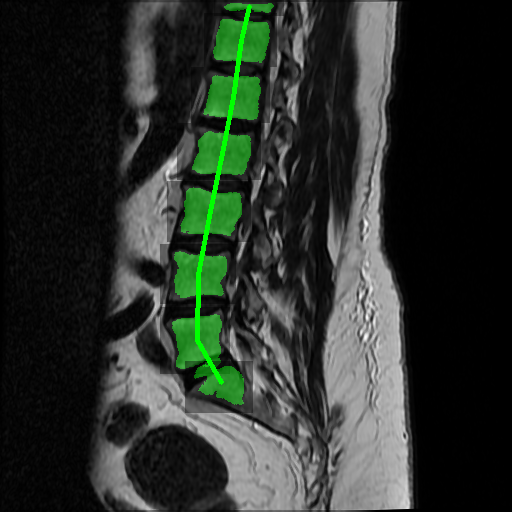

In [ ]:
# Show full overlay with both dots and lines
model.results[isx].plot_final_overlay(show_centers=True, show_lines=True)

# Show only lines on the overlay
model.results[isx].plot_final_overlay(show_centers=False, show_lines=True)

# Show only centers (dots)
model.results[isx].plot_final_overlay(show_centers=True, show_lines=False)

# Show only the overlay itself
model.results[isx].plot_final_overlay(show_centers=False, show_lines=False)

# Show standalone connectivity graph
model.results[isx].plot_center_lines_graph(show_points=True)

# Print sorted centers
print(model.results[isx].get_sorted_centers())

# Save overlay with only lines to file and display
model.results[isx].plot_lines_on_overlay(show=True, save_path="overlay_with_lines.png")

In [ ]:
!pip install gradio opencv-python


In [39]:
import gradio as gr
import cv2
import numpy as np
from PIL import Image

# Set which result to use (latest)
isx = -1

def analyze_image(input_img):
    try:
        # Convert PIL image to OpenCV format
        image = np.array(input_img.convert("RGB"))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Predict using BayuNet
        result = model.predict(image)

        # 1. Convert the prediction overlay to PIL
        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        overlay_image = Image.fromarray(result_rgb)

        # 2. Generate and load additional annotated image
        output_path = "overlay_with_lines.png"
        model.results[isx].plot_lines_on_overlay(show=True, save_path=output_path)
        lines_image = Image.open(output_path)

        # 3. Generate and load additional graph output
        output_path = "analysis_graph.png"
        model.results[isx].plot_center_lines_graph(show_points=True, save_path=output_path)
        graph_image = Image.open(output_path)

        return overlay_image, lines_image, graph_image

    except Exception as e:
        # Return error image and blank secondary
        blank = np.ones((300, 600, 3), dtype=np.uint8) * 255
        err_msg = f"❌ Error: {str(e)}"
        cv2.putText(blank, err_msg[:100], (10, 150), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 2)
        blank_pil = Image.fromarray(cv2.cvtColor(blank, cv2.COLOR_BGR2RGB))
        return blank_pil, blank_pil

# Launch Gradio interface with 2 image outputs
gr.Interface(
    fn=analyze_image,
    inputs=gr.Image(type="pil", label="Upload CT Scan"),
    outputs=[
        gr.Image(type="pil", label="Processed Output"),
        gr.Image(type="pil", label="Overlay with Center Lines"),
        gr.Image(type="pil", label="Manual Analysis Graph")
    ],
    title="BayuNet Spine Analysis",
    description="Upload a CT scan. BayuNet (YOLOv8 + U-Net) predicts and overlays vertebrae center lines."
).launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b12a7c6d2520870757.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


img shape is: (640, 576, 3)

0: 640x576 8 vertebreas, 36.7ms
Speed: 2.2ms preprocess, 36.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)
img shape is: (512, 512, 3)

0: 640x640 8 vertebreas, 36.7ms
Speed: 4.5ms preprocess, 36.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b12a7c6d2520870757.gradio.live
